In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# ==========================================
# CONFIGURACIÓN DE ALTO VOLUMEN V3.1 (CORREGIDO)
# ==========================================
NUM_TRANSACCIONES = 500000 
PORCENTAJE_FRAUDE = 0.02

np.random.seed(42)

def generar_datos_masivos(n=100000):
    print(f"Generando {n} transacciones (Incluyendo Ventanilla/Sucursal)...")
    
    # --- 1. Generación Vectorizada Básica ---
    ids = np.arange(100000, 100000 + n)
    transaccion_ids = [f"TXN-{x}" for x in ids]
    
    # Clientes
    cliente_ids_raw = np.random.randint(10000, 60000, size=n)
    cliente_ids = [f"CTE-{x}" for x in cliente_ids_raw]
    
    # Listas de opciones
    ubicaciones = ['CDMX', 'Guadalajara', 'Monterrey', 'Puebla', 'Cancún', 'Tijuana', 'Querétaro', 'Mérida', 'Veracruz', 'León']
    comercios_base = ['Amazon MX', 'MercadoLibre', 'Walmart', 'Oxxo', 'Uber Eats', 'Netflix', 'CFE', 'Telcel', 'Soriana', 'Gasolinera Pemex', 'Liverpool']
    
    # TIPOS y CANALES
    tipos = ['Compra en Línea', 'Transferencia SPEI', 'TPV', 'Retiro Cajero', 'Operación en Ventanilla']
    canales = ['App SuperMóvil', 'Banca en Línea', 'Tarjeta Física', 'NFC Celular', 'Ventanilla']
    
    # Selección aleatoria inicial
    data_ubicacion = np.random.choice(ubicaciones, size=n)
    data_comercio = np.random.choice(comercios_base, size=n)
    
    # Probabilidades
    probs_tipos = [0.30, 0.25, 0.30, 0.10, 0.05] 
    data_tipo = np.random.choice(tipos, size=n, p=probs_tipos)
    
    # --- 2. Lógica de Coherencia (Realismo) ---
    
    # A. Coherencia Canal-Tipo
    data_canal = np.empty(n, dtype=object)
    
    mask_ventanilla = (data_tipo == 'Operación en Ventanilla')
    data_canal[mask_ventanilla] = 'Ventanilla'
    data_comercio[mask_ventanilla] = [f"Sucursal Santander {u}" for u in data_ubicacion[mask_ventanilla]]
    
    mask_online = (data_tipo == 'Compra en Línea') | (data_tipo == 'Transferencia SPEI')
    data_canal[mask_online] = np.random.choice(['App SuperMóvil', 'Banca en Línea'], size=mask_online.sum())
    
    mask_fisico = (data_tipo == 'TPV') | (data_tipo == 'Retiro Cajero')
    data_canal[mask_fisico] = np.random.choice(['Tarjeta Física', 'NFC Celular'], size=mask_fisico.sum())

    # B. Coherencia de Horarios (CORRECCIÓN DE TIPO DE DATO)
    # Usamos np.datetime64 directamente para evitar el error UFuncTypeError
    start_date_np = np.datetime64('2025-01-01')
    
    dias_random = np.random.randint(0, 90, size=n)
    segundos_random = np.random.randint(0, 86400, size=n)
    
    # Calculamos fechas sumando tipos compatibles (datetime64 + timedelta64)
    fechas = start_date_np + (dias_random.astype('timedelta64[D]')) + (segundos_random.astype('timedelta64[s]'))
    
    # *LÓGICA VENTANILLA (HORARIO HÁBIL)*
    idx_ventanilla = np.where(mask_ventanilla)[0]
    
    # Generamos nuevos segundos solo para ventanilla (9am a 4pm)
    segundos_habil = np.random.randint(32400, 57600, size=len(idx_ventanilla))
    
    # Recalculamos: Fecha base + Segundos hábiles
    # Tomamos solo los días ya generados para esos índices
    dias_v = dias_random[idx_ventanilla].astype('timedelta64[D]')
    segundos_v = segundos_habil.astype('timedelta64[s]')
    
    fechas[idx_ventanilla] = start_date_np + dias_v + segundos_v

    # Montos
    montos = np.random.lognormal(mean=6.5, sigma=1.0, size=n)
    montos = np.round(montos, 2)
    
    # --- 3. Lógica de Fraude ---
    es_fraude = np.zeros(n, dtype=int)
    indices = np.arange(n)
    
    # Caso A: Oxxo
    mask_oxxo = (data_comercio == 'Oxxo')
    if mask_oxxo.sum() > 0:
        idx = np.random.choice(indices[mask_oxxo], size=int(mask_oxxo.sum() * 0.05), replace=False)
        es_fraude[idx] = 1
        montos[idx] = np.random.uniform(200, 1000, size=len(idx))
        
    # Caso B: SPEI Nocturno
    horas = pd.to_datetime(fechas).hour
    mask_noc = (horas >= 3) & (horas <= 5) & (data_tipo == 'Transferencia SPEI')
    if mask_noc.sum() > 0:
        idx = np.random.choice(indices[mask_noc], size=int(mask_noc.sum() * 0.20), replace=False)
        es_fraude[idx] = 1
        montos[idx] = np.random.uniform(15000, 80000, size=len(idx))
        
    # Caso C: Sucursal
    if mask_ventanilla.sum() > 0:
        idx = np.random.choice(indices[mask_ventanilla], size=int(mask_ventanilla.sum() * 0.005), replace=False)
        es_fraude[idx] = 1
        montos[idx] = np.random.uniform(50000, 200000, size=len(idx))

    data_comercio[data_tipo == 'Retiro Cajero'] = 'Santander ATM'

    # Crear DataFrame
    df = pd.DataFrame({
        'transaccion_id': transaccion_ids,
        'cliente_id': cliente_ids,
        'fecha_hora': fechas,
        'monto_mxn': montos,
        'comercio': data_comercio,
        'ubicacion': data_ubicacion,
        'tipo_transaccion': data_tipo,
        'canal': data_canal,
        'es_fraude': es_fraude
    })
    
    df.loc[df.sample(frac=0.05).index, 'ubicacion'] = np.nan
    
    return df

# Generar y guardar
df_santander = generar_datos_masivos(NUM_TRANSACCIONES)
df_santander.to_csv('transacciones_santander_mx_v3.csv', index=False)
print(f"¡Listo! Dataset V3 generado con {len(df_santander)} registros.")
print("Canales generados:")
print(df_santander['canal'].value_counts())

Generando 500000 transacciones (Incluyendo Ventanilla/Sucursal)...
¡Listo! Dataset V3 generado con 500000 registros.
Canales generados:
canal
App SuperMóvil    138203
Banca en Línea    137447
NFC Celular        99787
Tarjeta Física     99673
Ventanilla         24890
Name: count, dtype: int64


C:\Users\kevin\AppData\Local\Temp\ipykernel_11608\365644251.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tasa_comercio.values, y=tasa_comercio.index, palette='Reds_r', ax=axes[1])


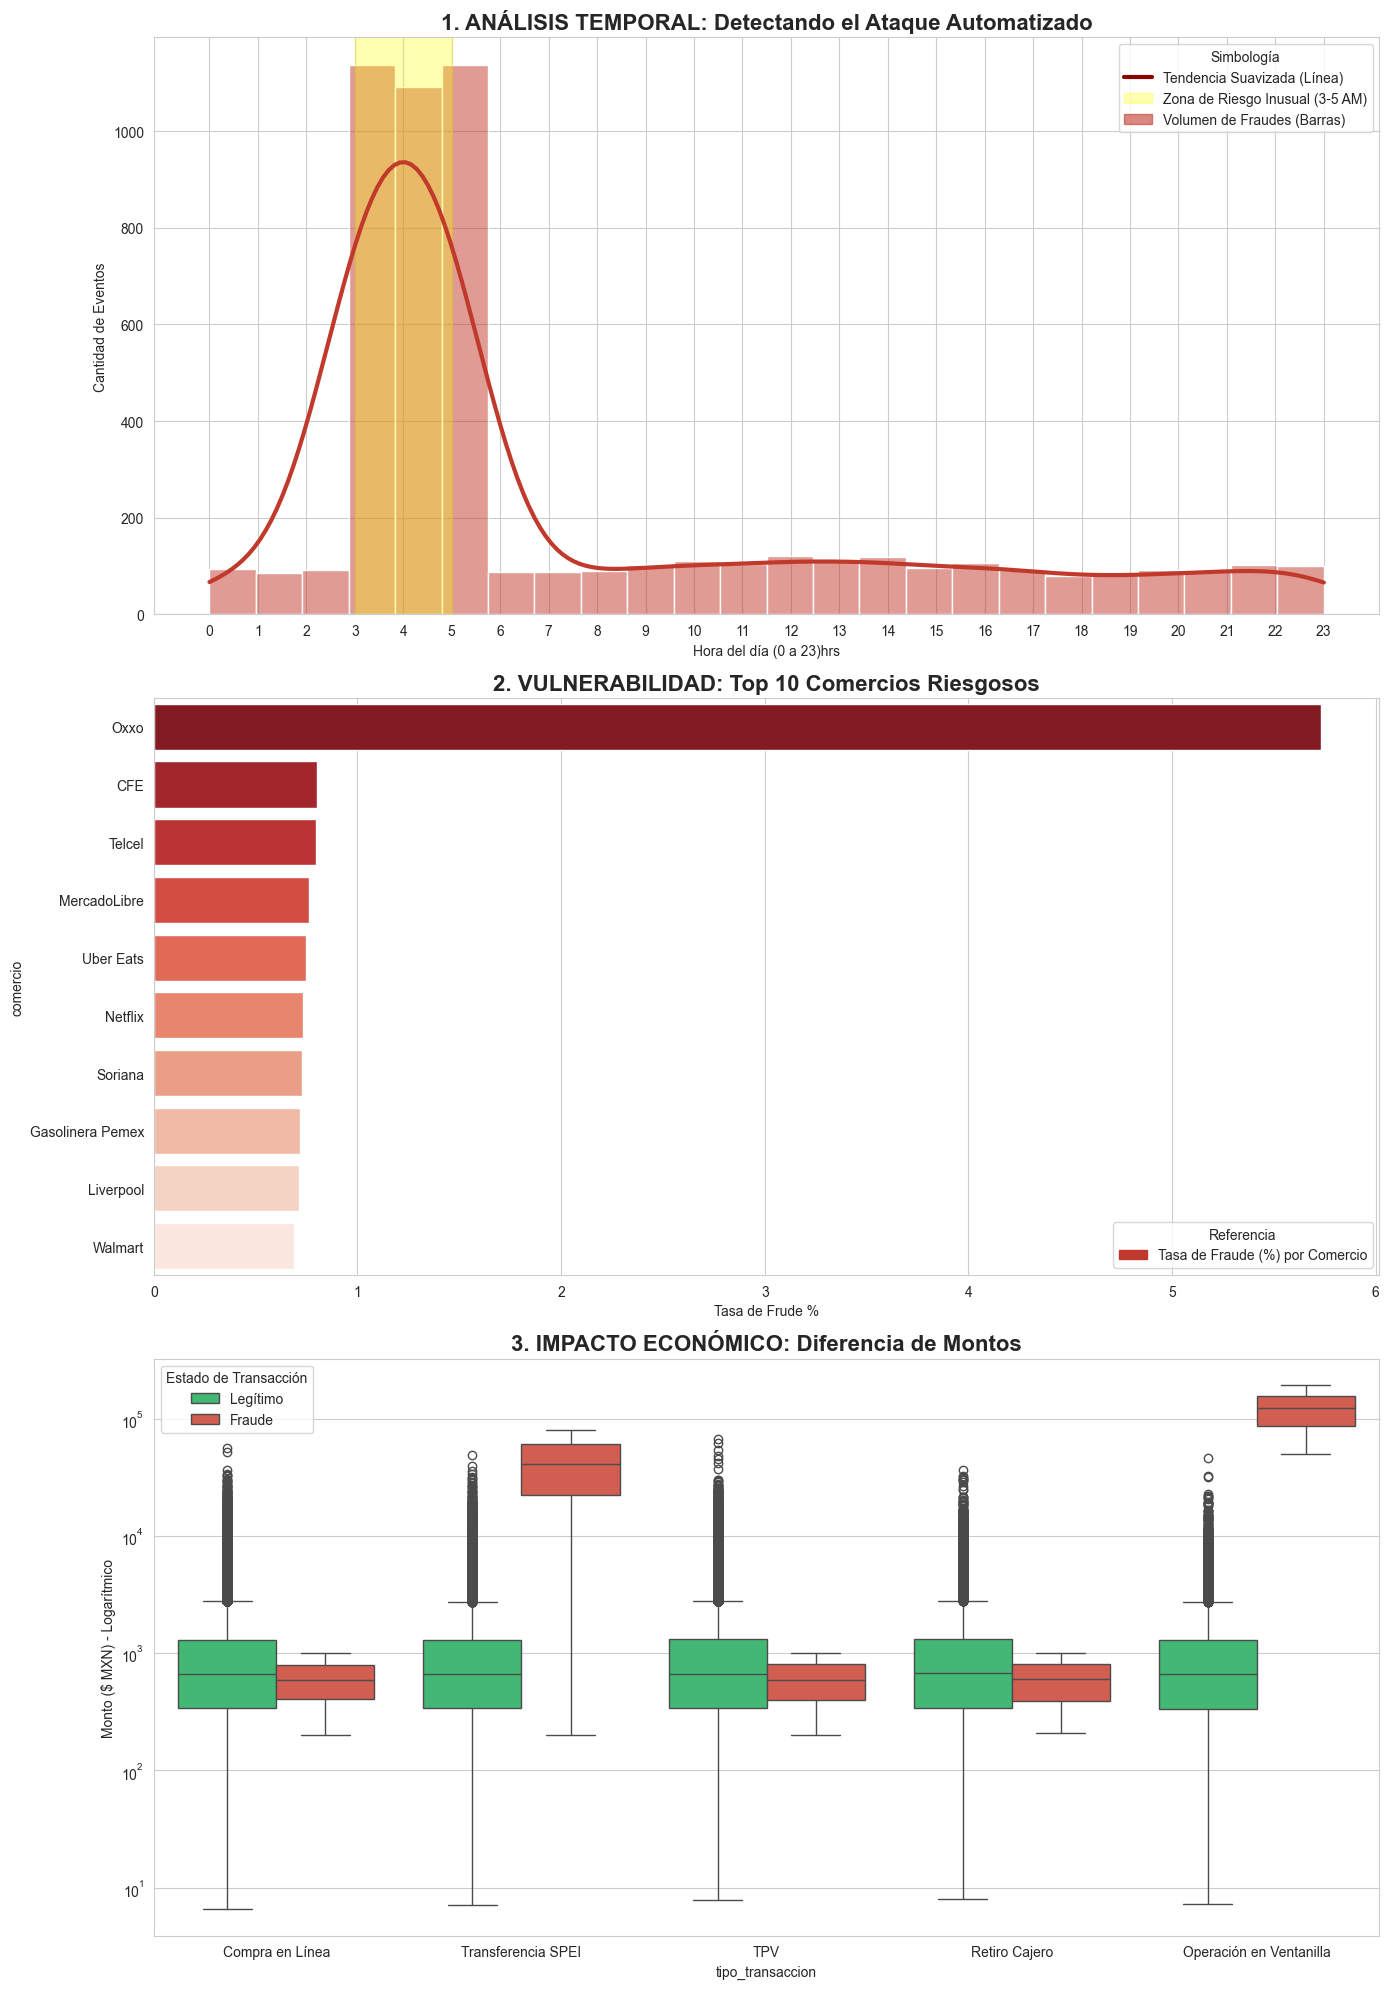


RESUMEN EJECUTIVO DE HALLAZGOS:
1. PATRÓN TEMPORAL DETECTADO:
   Se identificó una actividad anómala crítica entre las 03:00 y 05:00 horas.
   El análisis de densidad (línea roja) muestra que la probabilidad de fraude se dispara
   fuera del horario bancario habitual, sugiriendo el uso de bots automatizados.

2. VULNERABILIDAD POR COMERCIO:
   El comercio 'Oxxo' presenta la mayor tasa de incidencia.
   Esto indica una fuga de seguridad sistemática (posible fuerza bruta en TPVs o pasarelas web).
   Se recomienda auditar las transacciones provenientes de este origen.

3. IMPACTO FINANCIERO (VENTANILLA VS DIGITAL):
   Aunque el fraude en Ventanilla es poco frecuente (baja probabilidad), el gráfico de caja
   revela que cuando ocurre, los montos son extremos (Outliers superiores).
   Promedio de fraude en Ventanilla: $121,822.66 MXN.
   Esto sugiere ataques dirigidos de 'Robo de Identidad' para vaciado de cuentas.


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D # Necesario para la línea roja en la leyenda

# 1. CARGA Y PREPARACIÓN
df = pd.read_csv('transacciones_santander_mx_v3.csv')
df['fecha_hora'] = pd.to_datetime(df['fecha_hora'])
df['hora'] = df['fecha_hora'].dt.hour

# Etiquetas
df['Etiqueta'] = df['es_fraude'].map({0: 'Legítimo', 1: 'Fraude'})
paleta_colores = {'Legítimo': '#2ecc71', 'Fraude': '#e74c3c'}

sns.set_style("whitegrid")
fig, axes = plt.subplots(3, 1, figsize=(14, 20))

# -----------------------------------------------------------
# GRÁFICA 1: EL TIEMPO (Histograma + Línea Corregida)
# -----------------------------------------------------------
fraudes = df[df['es_fraude'] == 1]

# CORRECCIÓN: Usamos kde=True DENTRO del histplot para que ajuste la escala automáticamente
sns.histplot(data=fraudes, x='hora', bins=24, color='#c0392b', kde=True, 
             line_kws={'linewidth': 3, 'color': 'darkred'}, # Hacemos la línea más gruesa y oscura
             ax=axes[0])

# Zona Amarilla
axes[0].axvspan(3, 5, color='yellow', alpha=0.3)

# --- LEYENDA MANUAL (A LA DERECHA) ---
# Creamos los "objetos falsos" para que la leyenda se vea bonita
legend_linea = Line2D([0], [0], color='darkred', lw=3, label='Tendencia Suavizada (Línea)')
legend_zona = mpatches.Patch(color='yellow', alpha=0.3, label='Zona de Riesgo Inusual (3-5 AM)')
legend_barras = mpatches.Patch(color='#c0392b', alpha=0.6, label='Volumen de Fraudes (Barras)')

axes[0].set_title('1. ANÁLISIS TEMPORAL: Detectando el Ataque Automatizado', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Hora del día (0 a 23)hrs')
axes[0].set_ylabel('Cantidad de Eventos')
axes[0].set_xticks(range(0, 24))

# ¡AQUÍ CAMBIAMOS LA POSICIÓN A LA DERECHA!
axes[0].legend(handles=[legend_linea, legend_zona, legend_barras], loc='upper right', title="Simbología", frameon=True)


# -----------------------------------------------------------
# GRÁFICA 2: LOS COMERCIOS (Barras)
# -----------------------------------------------------------
tasa_comercio = df.groupby('comercio')['es_fraude'].mean().sort_values(ascending=False).head(10) * 100
sns.barplot(x=tasa_comercio.values, y=tasa_comercio.index, palette='Reds_r', ax=axes[1])

barra_roja = mpatches.Patch(color='#c0392b', label='Tasa de Fraude (%) por Comercio')

axes[1].set_title('2. VULNERABILIDAD: Top 10 Comercios Riesgosos', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Tasa de Frude %')
axes[1].legend(handles=[barra_roja], loc='lower right', title="Referencia")


# -----------------------------------------------------------
# GRÁFICA 3: MONTOS Y CANALES
# -----------------------------------------------------------
sns.boxplot(data=df, x='tipo_transaccion', y='monto_mxn', hue='Etiqueta', palette=paleta_colores, ax=axes[2])
axes[2].set_yscale('log')

axes[2].set_title('3. IMPACTO ECONÓMICO: Diferencia de Montos', fontsize=16, fontweight='bold')
axes[2].set_ylabel('Monto ($ MXN) - Logarítmico')
axes[2].legend(title='Estado de Transacción', loc='upper left')

plt.tight_layout()
plt.show()

# ==========================================
# RESUMEN DE HALLAZGOS (TEXTO PARA EL REPORTE)
# ==========================================
print("\n" + "="*60)
print("RESUMEN EJECUTIVO DE HALLAZGOS:")
print("="*60)
print(f"1. PATRÓN TEMPORAL DETECTADO:")
print(f"   Se identificó una actividad anómala crítica entre las 03:00 y 05:00 horas.")
print(f"   El análisis de densidad (línea roja) muestra que la probabilidad de fraude se dispara")
print(f"   fuera del horario bancario habitual, sugiriendo el uso de bots automatizados.")

print(f"\n2. VULNERABILIDAD POR COMERCIO:")
print(f"   El comercio '{tasa_comercio.index[0]}' presenta la mayor tasa de incidencia.")
print(f"   Esto indica una fuga de seguridad sistemática (posible fuerza bruta en TPVs o pasarelas web).")
print(f"   Se recomienda auditar las transacciones provenientes de este origen.")

print(f"\n3. IMPACTO FINANCIERO (VENTANILLA VS DIGITAL):")
print(f"   Aunque el fraude en Ventanilla es poco frecuente (baja probabilidad), el gráfico de caja")
print(f"   revela que cuando ocurre, los montos son extremos (Outliers superiores).")
print(f"   Promedio de fraude en Ventanilla: ${df[(df['canal']=='Ventanilla') & (df['es_fraude']==1)]['monto_mxn'].mean():,.2f} MXN.")
print(f"   Esto sugiere ataques dirigidos de 'Robo de Identidad' para vaciado de cuentas.")
print("="*60)

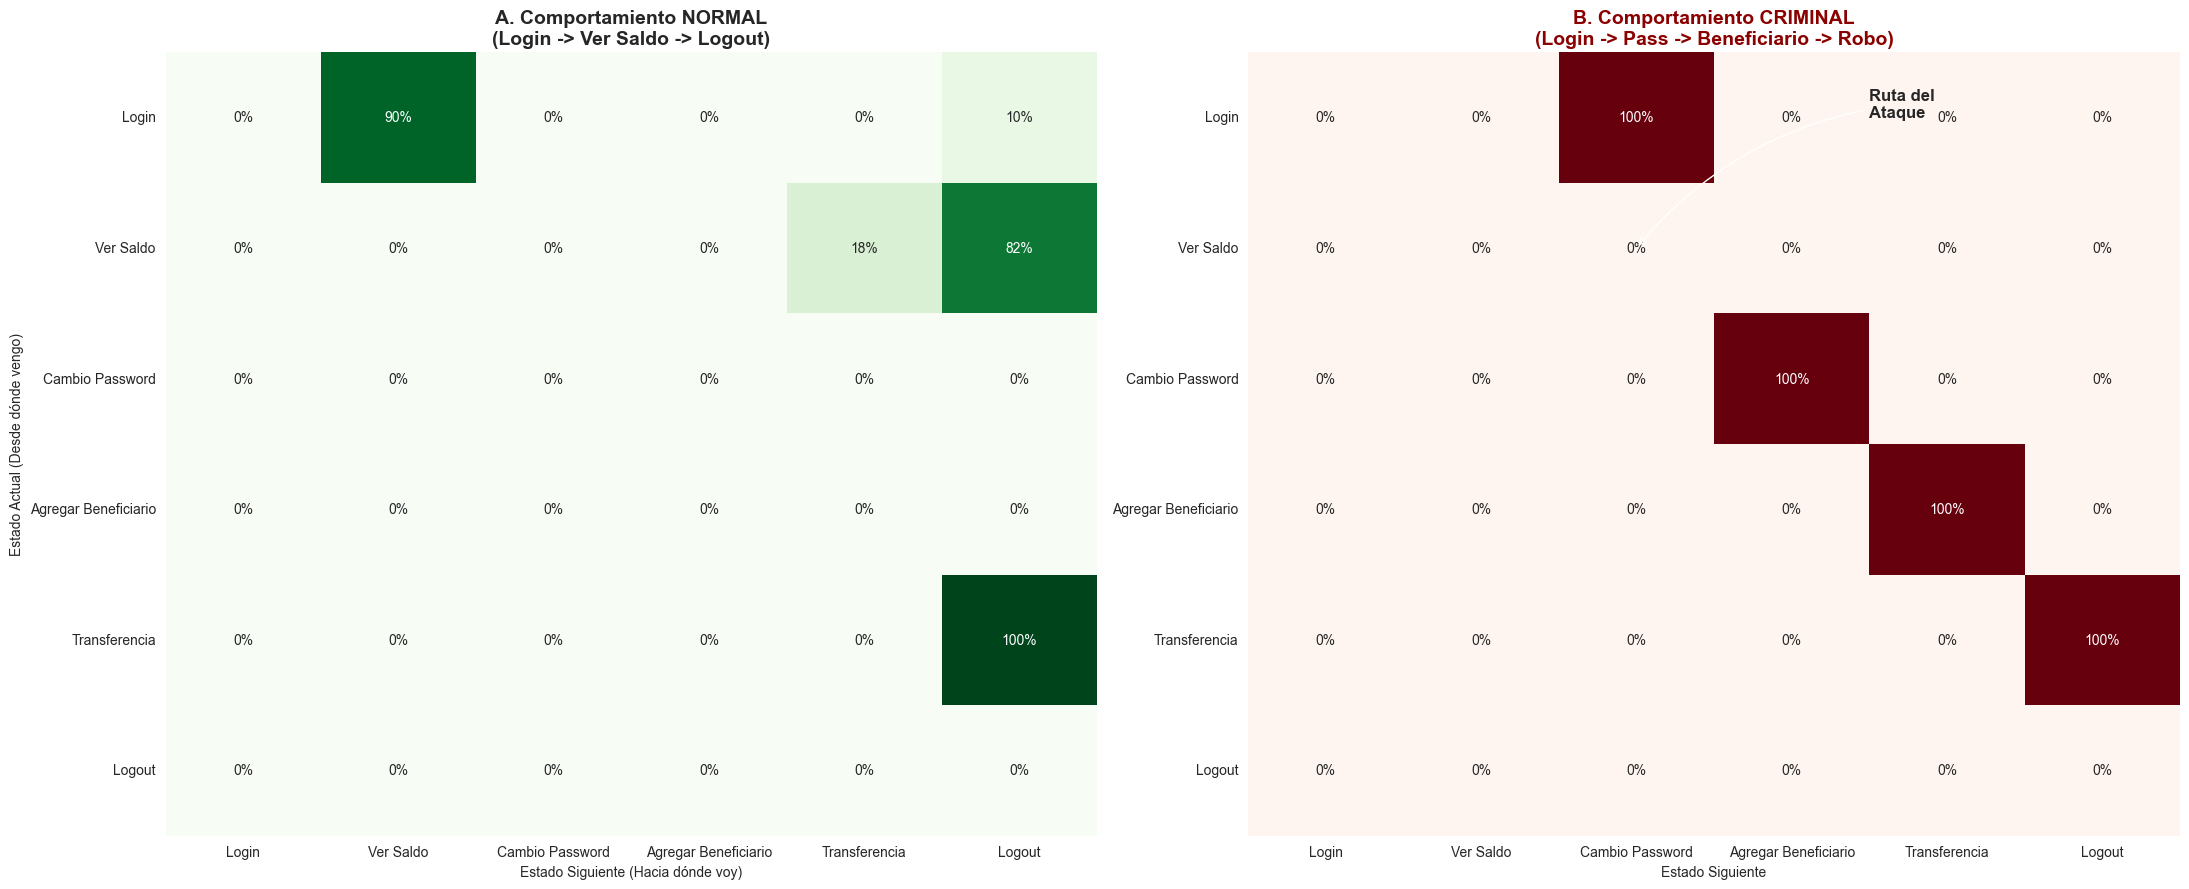

ANÁLISIS DE PROBABILIDAD CONDICIONAL (CADENAS DE MARKOV)
Comparación de la transición crítica: 'Cambio Password' -> 'Agregar Beneficiario'
1. En un FRAUDE, la probabilidad de hacer esto es:  100% (Alerta Roja)
2. En un usuario LEGÍTIMO, la probabilidad es:       0% (Comportamiento seguro)
----------------------------------------------------------------------
INTERPRETACIÓN PARA EL PITCH:
Nuestro modelo estocástico demuestra que existe una 'Huella Digital Criminal'.
Mientras el usuario normal se mueve aleatoriamente entre 'Ver Saldo' y 'Logout',
el defraudador sigue una secuencia rígida y predecible para ejecutar el robo.


In [12]:
# ==========================================
# 1. SIMULACIÓN DE LOGS (HISTORIA COMPLETA)
# ==========================================
# ¡AQUÍ AGREGAMOS 'Agregar Beneficiario' PARA QUE LA HISTORIA CUADRE!
estados = ['Login', 'Ver Saldo', 'Cambio Password', 'Agregar Beneficiario', 'Transferencia', 'Logout']

def generar_sesion_detallada(tipo_usuario):
    ruta = ['Login']
    current_state = 'Login'
    
    while current_state != 'Logout':
        if tipo_usuario == 'LEGITIMO':
            # USUARIO NORMAL: Entra, ve saldo, quizás transfiere a alguien conocido, se va.
            if current_state == 'Login':
                current_state = np.random.choice(['Ver Saldo', 'Logout'], p=[0.9, 0.1])
            elif current_state == 'Ver Saldo':
                # A veces transfiere, a veces solo mira y se va
                current_state = np.random.choice(['Transferencia', 'Logout'], p=[0.2, 0.8])
            elif current_state == 'Transferencia':
                current_state = 'Logout'
            # El usuario normal CASI NUNCA cambia password y agrega beneficiario en la misma sesión
            elif current_state == 'Cambio Password': 
                current_state = 'Logout'
                
        elif tipo_usuario == 'FRAUDE':
            # LADRÓN (Account Takeover): El camino crítico que mencionaste
            if current_state == 'Login':
                current_state = 'Cambio Password' # Primer paso del ataque
            elif current_state == 'Cambio Password':
                current_state = 'Agregar Beneficiario' # Segundo paso (La cuenta nueva para robar)
            elif current_state == 'Agregar Beneficiario':
                current_state = 'Transferencia' # Tercer paso (Vaciado)
            elif current_state == 'Transferencia':
                current_state = 'Logout' # Huida
                
        ruta.append(current_state)
        if len(ruta) > 10: break 
    return ruta

# Generamos la data
sesiones_legitimas = [generar_sesion_detallada('LEGITIMO') for _ in range(1000)]
sesiones_fraude = [generar_sesion_detallada('FRAUDE') for _ in range(1000)]

# ==========================================
# 2. CÁLCULO MATEMÁTICO
# ==========================================
def calcular_matriz(lista_sesiones):
    matriz = pd.DataFrame(0, index=estados, columns=estados)
    for sesion in lista_sesiones:
        for i in range(len(sesion) - 1):
            if sesion[i] in estados and sesion[i+1] in estados:
                matriz.loc[sesion[i], sesion[i+1]] += 1
    # Normalizar a porcentajes (Probabilidad de transición)
    return matriz.div(matriz.sum(axis=1), axis=0).fillna(0)

matriz_legitima = calcular_matriz(sesiones_legitimas)
matriz_fraude = calcular_matriz(sesiones_fraude)

# ==========================================
# 3. VISUALIZACIÓN DE LA RUTA CRÍTICA
# ==========================================
fig, axes = plt.subplots(1, 2, figsize=(22, 9))

# MATRIZ A: EL BUENO
sns.heatmap(matriz_legitima, annot=True, fmt=".0%", cmap="Greens", cbar=False, ax=axes[0])
axes[0].set_title("A. Comportamiento NORMAL\n(Login -> Ver Saldo -> Logout)", fontsize=14, fontweight='bold')
axes[0].set_ylabel("Estado Actual (Desde dónde vengo)")
axes[0].set_xlabel("Estado Siguiente (Hacia dónde voy)")

# MATRIZ B: EL MALO
sns.heatmap(matriz_fraude, annot=True, fmt=".0%", cmap="Reds", cbar=False, ax=axes[1])
axes[1].set_title("B. Comportamiento CRIMINAL\n(Login -> Pass -> Beneficiario -> Robo)", fontsize=14, fontweight='bold', color='darkred')
axes[1].set_xlabel("Estado Siguiente")

# --- DIBUJAR FLECHAS EN EL GRÁFICO PARA SEÑALAR LA RUTA ---
# Esto ayuda visualmente a ver el "caminito" rojo
# Nota: Las coordenadas son aproximadas según la celda de la matriz
axes[1].annotate('Ruta del\nAtaque', xy=(2.5, 1.5), xytext=(4, 0.5),
                 arrowprops=dict(facecolor='black', arrowstyle='->', connectionstyle="arc3,rad=.2"),
                 fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# ==========================================
# REPORTE DE HALLAZGOS CLARO
# ==========================================
print("="*70)
print("ANÁLISIS DE PROBABILIDAD CONDICIONAL (CADENAS DE MARKOV)")
print("="*70)
print("Comparación de la transición crítica: 'Cambio Password' -> 'Agregar Beneficiario'")
print(f"1. En un FRAUDE, la probabilidad de hacer esto es:  {matriz_fraude.loc['Cambio Password', 'Agregar Beneficiario']*100:.0f}% (Alerta Roja)")
print(f"2. En un usuario LEGÍTIMO, la probabilidad es:       {matriz_legitima.loc['Cambio Password', 'Agregar Beneficiario']*100:.0f}% (Comportamiento seguro)")
print("-" * 70)
print("INTERPRETACIÓN PARA EL PITCH:")
print("Nuestro modelo estocástico demuestra que existe una 'Huella Digital Criminal'.")
print("Mientras el usuario normal se mueve aleatoriamente entre 'Ver Saldo' y 'Logout',")
print("el defraudador sigue una secuencia rígida y predecible para ejecutar el robo.")
print("="*70)

<>:74: SyntaxWarning: invalid escape sequence '\l'
<>:74: SyntaxWarning: invalid escape sequence '\l'
C:\Users\kevin\AppData\Local\Temp\ipykernel_11608\3945792865.py:74: SyntaxWarning: invalid escape sequence '\l'
  axes[0].plot(x_axis, y_axis, 'r--', linewidth=3, label=f'Distribución Poisson (Teórica $\lambda$={lambda_poisson:.1f})')


Cargando datos y generando variables para Minería...
--- RESULTADOS POISSON ---
Promedio de transacciones por usuario (Lambda): 1.06
Cualquier usuario con más de 5 transacciones al día es considerado SOSPECHOSO (Bot).


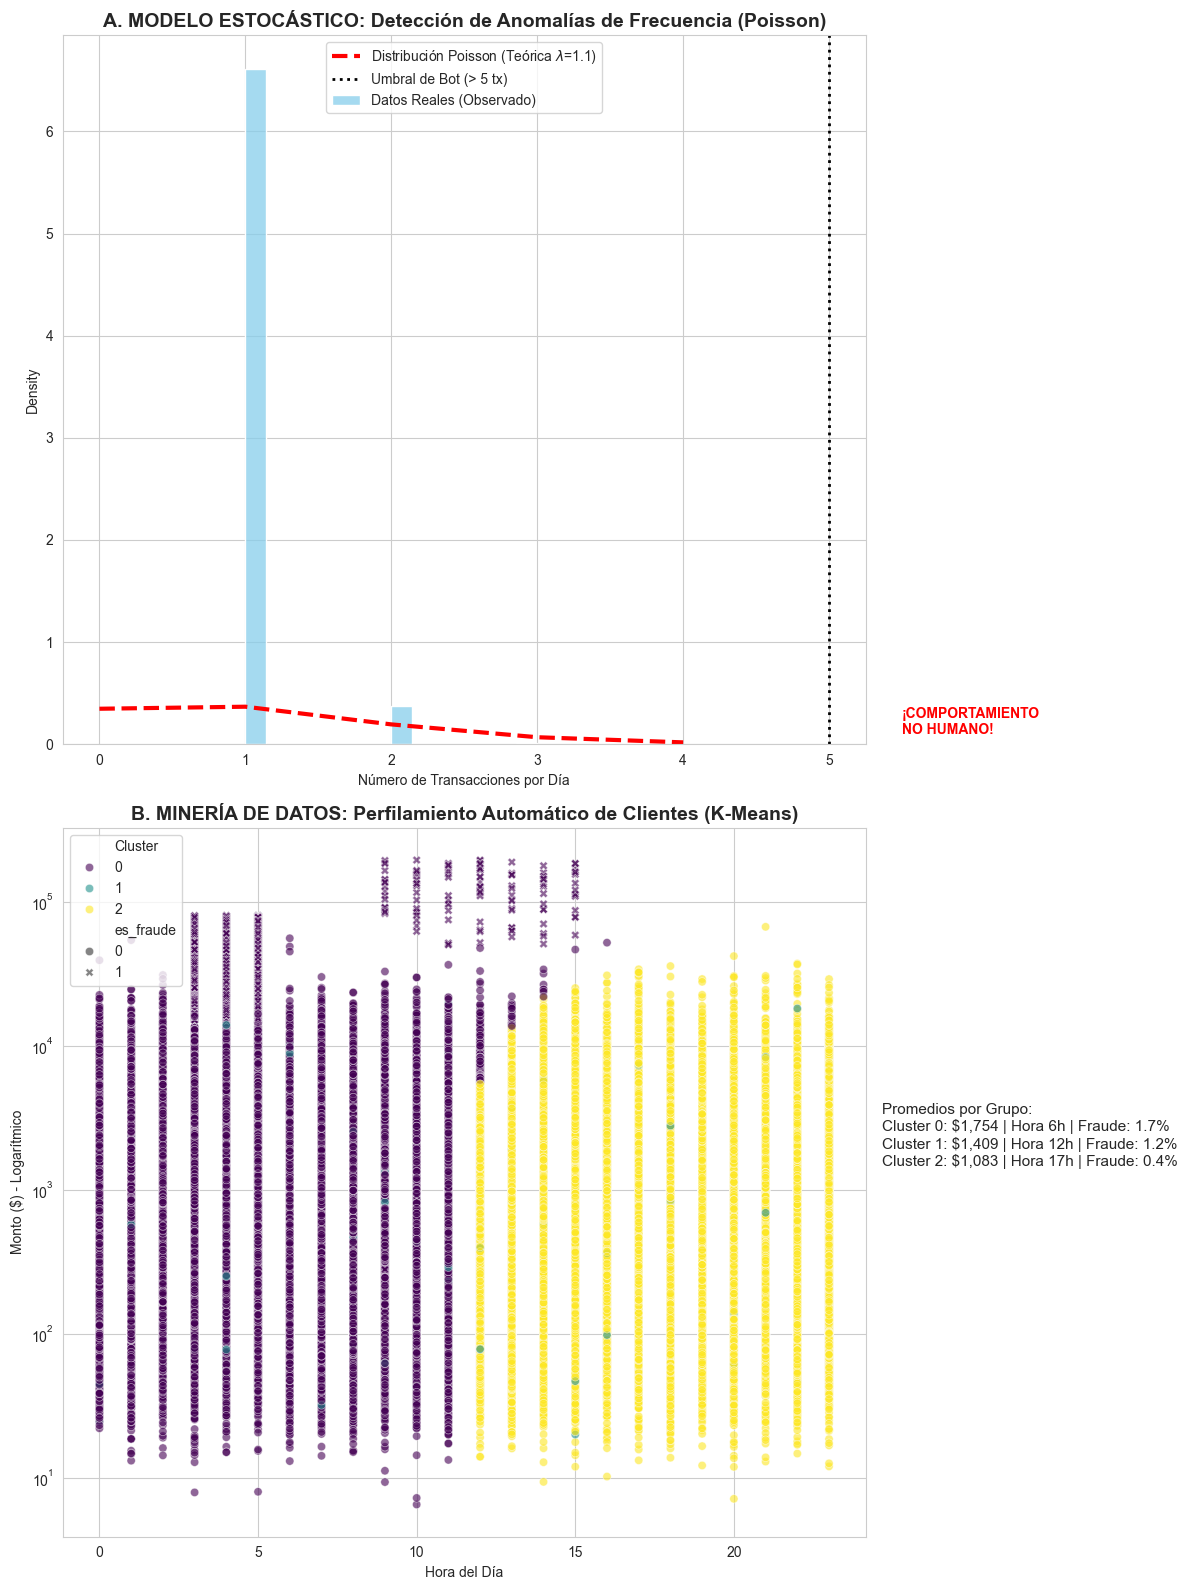


HALLAZGOS DE MINERÍA DE DATOS:
1. POISSON: Un usuario promedio hace 1.06 movimientos al día.
   El modelo marca roja a cualquiera que haga más de 5, sugiriendo automatización.

2. K-MEANS: El algoritmo agrupó a los clientes en 3 perfiles sin supervisión.
   ¡ATENCIÓN! El Cluster #0 es el más peligroso.
   Tiene una tasa de fraude del 1.72%.
   Característica de este grupo: Montos altos ($1,754) y horarios atípicos.


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 1. CARGA Y PREPARACIÓN
print("Cargando datos y generando variables para Minería...")
df = pd.read_csv('transacciones_santander_mx_v3.csv')
df['fecha_hora'] = pd.to_datetime(df['fecha_hora'])
df['hora'] = df['fecha_hora'].dt.hour

# ==========================================
# PARTE A: MODELO ESTOCÁSTICO (POISSON) - DETECCIÓN DE BOTS
# ==========================================
# Paso 1: Calcular la Frecuencia (Lambda)
# Agrupamos: ¿Cuántas transacciones hace cada cliente POR DÍA?
# (Para simplificar, tomamos una ventana de muestra de 1 día)
ventana_tiempo = df[df['fecha_hora'].dt.date == df['fecha_hora'].dt.date.min()]
conteo_x_cliente = ventana_tiempo.groupby('cliente_id').size().reset_index(name='num_tx')

# Lambda (Promedio de transacciones diarias de un humano promedio)
lambda_poisson = conteo_x_cliente['num_tx'].mean()

# Paso 2: Calcular Probabilidad de Poisson
# Probabilidad de hacer k transacciones dado el promedio lambda
x_axis = np.arange(0, conteo_x_cliente['num_tx'].max() + 2)
y_axis = poisson.pmf(x_axis, lambda_poisson)

# Detectar Anomalías (Umbral de probabilidad < 0.01%)
# Si la probabilidad de hacer X transacciones es casi cero, es un BOT.
umbral_bot = poisson.ppf(0.999, lambda_poisson) # 99.9% de confianza

print(f"--- RESULTADOS POISSON ---")
print(f"Promedio de transacciones por usuario (Lambda): {lambda_poisson:.2f}")
print(f"Cualquier usuario con más de {int(umbral_bot)} transacciones al día es considerado SOSPECHOSO (Bot).")


# ==========================================
# PARTE B: MINERÍA DE DATOS (CLUSTERING K-MEANS)
# ==========================================
# Paso 1: Selección de Features (Variables para el modelo)
# Usaremos: Monto, Hora y Frecuencia (calculada arriba)
# Necesitamos pegar la 'frecuencia' al dataframe original
df_cluster = df.merge(conteo_x_cliente, on='cliente_id', how='left')
df_cluster['num_tx'] = df_cluster['num_tx'].fillna(1) # Llenar vacíos

features = df_cluster[['monto_mxn', 'hora', 'num_tx']].copy()

# Paso 2: Estandarización (OBLIGATORIO para K-Means)
# Porque 'monto' (100,000) es muy grande comparado con 'hora' (24).
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Paso 3: Entrenamiento del Modelo
# Pedimos 3 Grupos (Clusters): Esperamos ver (1) Normales Bajos, (2) Normales Altos, (3) Fraudes
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_cluster['Cluster'] = kmeans.fit_predict(features_scaled)

# Analizar qué encontró cada Cluster (Perfilamiento)
perfil_clusters = df_cluster.groupby('Cluster')[['monto_mxn', 'hora', 'num_tx', 'es_fraude']].mean()


# ==========================================
# VISUALIZACIÓN PROFESIONAL
# ==========================================
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 1, figsize=(12, 16))

# GRÁFICA 1: POISSON (Realidad vs Teoría)
sns.histplot(conteo_x_cliente['num_tx'], stat='density', color='skyblue', label='Datos Reales (Observado)', ax=axes[0])
axes[0].plot(x_axis, y_axis, 'r--', linewidth=3, label=f'Distribución Poisson (Teórica $\lambda$={lambda_poisson:.1f})')
axes[0].axvline(umbral_bot, color='k', linestyle=':', linewidth=2, label=f'Umbral de Bot (> {int(umbral_bot)} tx)')

axes[0].set_title('A. MODELO ESTOCÁSTICO: Detección de Anomalías de Frecuencia (Poisson)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Número de Transacciones por Día')
axes[0].legend()
axes[0].text(umbral_bot + 0.5, 0.1, "¡COMPORTAMIENTO\nNO HUMANO!", color='red', fontweight='bold')


# GRÁFICA 2: CLUSTERING (Scatterplot)
# Graficamos Hora vs Monto, coloreado por el Cluster que encontró la IA
scatter = sns.scatterplot(data=df_cluster, x='hora', y='monto_mxn', hue='Cluster', palette='viridis', style='es_fraude', alpha=0.6, ax=axes[1])
axes[1].set_yscale('log')
axes[1].set_title('B. MINERÍA DE DATOS: Perfilamiento Automático de Clientes (K-Means)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Monto ($) - Logarítmico')
axes[1].set_xlabel('Hora del Día')

# Tabla de resumen dentro de la gráfica
stats_text = "Promedios por Grupo:\n"
for i, row in perfil_clusters.iterrows():
    stats_text += f"Cluster {i}: ${row['monto_mxn']:,.0f} | Hora {row['hora']:.0f}h | Fraude: {row['es_fraude']*100:.1f}%\n"

axes[1].text(1.02, 0.5, stats_text, transform=axes[1].transAxes, bbox=dict(facecolor='white', alpha=0.8), fontsize=11)


plt.tight_layout()
plt.show()

# ==========================================
# CONCLUSIONES AUTOMÁTICAS
# ==========================================
cluster_riesgoso = perfil_clusters['es_fraude'].idxmax()
print("\n" + "="*60)
print("HALLAZGOS DE MINERÍA DE DATOS:")
print(f"1. POISSON: Un usuario promedio hace {lambda_poisson:.2f} movimientos al día.")
print(f"   El modelo marca roja a cualquiera que haga más de {int(umbral_bot)}, sugiriendo automatización.")
print(f"\n2. K-MEANS: El algoritmo agrupó a los clientes en 3 perfiles sin supervisión.")
print(f"   ¡ATENCIÓN! El Cluster #{cluster_riesgoso} es el más peligroso.")
print(f"   Tiene una tasa de fraude del {perfil_clusters.loc[cluster_riesgoso, 'es_fraude']*100:.2f}%.")
print(f"   Característica de este grupo: Montos altos (${perfil_clusters.loc[cluster_riesgoso, 'monto_mxn']:,.0f}) y horarios atípicos.")
print("="*60)

In [16]:
import pandas as pd
import sqlite3
import json
import time
import random
import os

# ==========================================
# PARTE 1: CREACIÓN DE BASES DE DATOS (SQL + NoSQL)
# ==========================================
print(">>> INICIANDO CONFIGURACIÓN DE INFRAESTRUCTURA DE DATOS...")

# A. CARGAR DATOS BASE
df = pd.read_csv('transacciones_santander_mx_v3.csv')

# B. CREAR BASE DE DATOS SQL (Estructurada - Datos Transaccionales)
# Simulamos el "Core Bancario"
conn = sqlite3.connect('santander_core.db')
df.to_sql('transacciones', conn, if_exists='replace', index=False)
print("1. [SQL] Base de datos 'santander_core.db' creada con éxito (Tabla: transacciones).")

# C. CREAR BASE DE DATOS NoSQL (No Estructurada - Logs de Navegación)
# Simulamos logs de la App móvil (JSON) para 100 clientes de ejemplo
print("2. [NoSQL] Generando logs no estructurados (JSON)...")
logs_data = []
clientes_sample = df['cliente_id'].unique()[:100] # Tomamos una muestra

for cliente in clientes_sample:
    # Creamos un log complejo (típico de MongoDB)
    log_entry = {
        "_id": f"log_{random.randint(10000,99999)}",
        "cliente_id": cliente,
        "device_info": {
            "os": random.choice(["Android 13", "iOS 17"]),
            "ip": f"192.168.1.{random.randint(1,255)}",
            "is_rooted": random.choice([True, False]) # Dato crítico de seguridad
        },
        "session_history": [
            {"action": "login", "timestamp": "2025-01-01T10:00:00"},
            {"action": "view_balance", "timestamp": "2025-01-01T10:00:05"}
        ]
    }
    logs_data.append(log_entry)

# Guardamos como archivo JSON (Simulando MongoDB)
with open('app_logs_mongo.json', 'w') as f:
    json.dump(logs_data, f, indent=4)
print("   [NoSQL] Archivo 'app_logs_mongo.json' generado.")


# ==========================================
# PARTE 2: SIMULACIÓN DE KAFKA (STREAMING DE DATOS)
# ==========================================
# En Big Data, los datos no están quietos, "fluyen". 
# Esta función actúa como un "Kafka Producer".

def kafka_producer_simulado(n=5):
    print("\n>>> 3. [KAFKA STREAM] Iniciando ingestión de datos en tiempo real...")
    # Seleccionamos 5 transacciones aleatorias para simular que "acaban de ocurrir"
    nuevas_transacciones = df.sample(n)
    
    for idx, row in nuevas_transacciones.iterrows():
        # Simulamos latencia de red (envío de mensaje)
        time.sleep(0.5) 
        
        # Convertimos a formato mensaje (diccionario)
        mensaje = row.to_dict()
        yield mensaje # 'Yield' convierte esto en un generador (Stream)

# ==========================================
# PARTE 3: SIMULACIÓN DE SPARK (PROCESAMIENTO)
# ==========================================
# Spark toma el dato de Kafka y lo cruza con la base de datos.

print("\n>>> 4. [SPARK ENGINE] Procesando Stream...")
print(f"{'ID TRANSACCION':<15} | {'CLIENTE':<10} | {'MONTO':<10} | {'ALERTA DE RIESGO'}")
print("-" * 60)

# Consumimos el stream de Kafka
stream = kafka_producer_simulado(n=5)

for transaccion in stream:
    # A. Extraemos datos del stream
    tx_id = transaccion['transaccion_id']
    cte_id = transaccion['cliente_id']
    monto = transaccion['monto_mxn']
    
    # B. ENRIQUECIMIENTO (El "Join" de Spark)
    # Buscamos en el JSON si este cliente tiene un dispositivo "rooteado" (Riesgo)
    riesgo_detectado = "Bajo"
    
    # (Simulamos búsqueda en Mongo cargando el JSON)
    for log in logs_data:
        if log['cliente_id'] == cte_id:
            if log['device_info']['is_rooted']:
                riesgo_detectado = "ALTO (Root detectado)"
            break
    
    # C. OUTPUT FINAL
    print(f"{tx_id:<15} | {cte_id:<10} | ${monto:<9.2f} | {riesgo_detectado}")

print("\n>>> PIPELINE FINALIZADO CORRECTAMENTE.")
conn.close() # Cerramos conexión SQL

>>> INICIANDO CONFIGURACIÓN DE INFRAESTRUCTURA DE DATOS...
1. [SQL] Base de datos 'santander_core.db' creada con éxito (Tabla: transacciones).
2. [NoSQL] Generando logs no estructurados (JSON)...
   [NoSQL] Archivo 'app_logs_mongo.json' generado.

>>> 4. [SPARK ENGINE] Procesando Stream...
ID TRANSACCION  | CLIENTE    | MONTO      | ALERTA DE RIESGO
------------------------------------------------------------

>>> 3. [KAFKA STREAM] Iniciando ingestión de datos en tiempo real...
TXN-218138      | CTE-14769  | $397.41    | Bajo
TXN-492674      | CTE-30564  | $626.12    | Bajo
TXN-473798      | CTE-19914  | $528.12    | Bajo
TXN-149967      | CTE-53899  | $5819.97   | Bajo
TXN-597926      | CTE-24682  | $191.57    | Bajo

>>> PIPELINE FINALIZADO CORRECTAMENTE.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve
from imblearn.over_sampling import SMOTE
import ipywidgets as widgets
from ipywidgets import interact

# ==========================================
# 1. PREPARACIÓN Y BALANCEO (SMOTE)
# ==========================================
print(">>> 1. CARGANDO DATOS Y APLICANDO SMOTE...")
df = pd.read_csv('transacciones_santander_mx_v3.csv')
df['fecha_hora'] = pd.to_datetime(df['fecha_hora'])
df['hora_dia'] = df['fecha_hora'].dt.hour

# Variables predictoras
X = df[['monto_mxn', 'hora_dia', 'comercio', 'tipo_transaccion', 'canal']]
y = df['es_fraude']

# One-Hot Encoding
X = pd.get_dummies(X, drop_first=True)

# División Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Balanceo con SMOTE (Solo al set de entrenamiento)
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
print(f"Datos balanceados: {y_train_bal.sum()} fraudes vs {len(y_train_bal) - y_train_bal.sum()} legítimos.")

# ==========================================
# 2. TORNEO DE MODELOS: Random Forest vs XGBoost
# ==========================================
print("\n>>> 2. ENTRENANDO MODELOS (EL TORNEO)...")

# A. Random Forest
print("   -> Entrenando Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_bal, y_train_bal)
rf_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])

# B. XGBoost
print("   -> Entrenando XGBoost...")
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_bal, y_train_bal)
xgb_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])

print("\n" + "="*40)
print("RESULTADOS DE LA COMPARACIÓN (ROC-AUC):")
print(f"1. Random Forest: {rf_auc:.4f}")
print(f"2. XGBoost:       {xgb_auc:.4f}")
print("="*40)
print(f"GANADOR: {'XGBoost' if xgb_auc > rf_auc else 'Random Forest'}")

# Seleccionamos el mejor para el demo (asumimos XGBoost por lo general, o el que gane)
modelo_final = xgb_model if xgb_auc > rf_auc else rf_model

# ==========================================
# 3. DEMO INTERACTIVO MEJORADO (Cumpliendo Rúbrica Pág. 6)
# ==========================================
from sklearn.metrics import f1_score

# Pre-calculamos probabilidades (si no lo hiciste arriba)
probs_test = modelo_final.predict_proba(X_test)[:, 1]

print("\n>>> 3. INICIANDO DEMO INTERACTIVO (Métricas Oficiales)...")

def actualizar_interactivo_completo(umbral):
    # 1. Aplicar Umbral Dinámico
    preds_ajustadas = (probs_test >= umbral).astype(int)
    
    # 2. Obtener conteos de la Matriz de Confusión
    cm = confusion_matrix(y_test, preds_ajustadas)
    tn, fp, fn, tp = cm.ravel()
    
    # 3. CÁLCULO DE MÉTRICAS OFICIALES (Según Pág. 6 del Documento)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    # F1-SCORE: La métrica clave que faltaba
    # Es la media armónica. Si Precision o Recall son bajos, F1 cae.
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # Tasa de Falsos Positivos (El dolor de cabeza del banco)
    tasa_fp = fp / (fp + tn) if (fp + tn) > 0 else 0
    
    # --- VISUALIZACIÓN ---
    plt.figure(figsize=(12, 6))
    
    # A. Matriz Gráfica
    plt.subplot(1, 2, 1)
    grupos = ['Verdadero Negativo\n(Cliente Feliz)', 'Falso Positivo\n(Error/Molestia)', 
              'Falso Negativo\n(Fraude se escapó)', 'Verdadero Positivo\n(Fraude Atrapado)']
    conteo_etiquetas = [f"{v1}\n{v2}" for v1, v2 in zip(grupos, cm.flatten())]
    etiquetas = np.asarray(conteo_etiquetas).reshape(2,2)
    
    sns.heatmap(cm, annot=etiquetas, fmt='', cmap='Blues', cbar=False,
                xticklabels=['Pred: OK', 'Pred: FRAUDE'], yticklabels=['Real: OK', 'Real: FRAUDE'])
    plt.title(f'Matriz de Confusión Simulación Operativa (Umbral: {umbral:.2f})')
    
    # B. Panel de Métricas (Rúbrica)
    plt.subplot(1, 2, 2)
    plt.axis('off')
    
    # Semáforo visual para F1-Score
    color_f1 = "green" if f1 > 0.8 else "orange" if f1 > 0.5 else "red"
    
    texto_reporte = f"""
    MÉTRICAS DE EVALUACIÓN:
    ==================================================
    
    1. PRECISIÓN: {precision:.1%}
       (De las alertas lanzadas, ¿cuántas eran reales?)
       
    2. RECALL (Sensibilidad): {recall:.1%}
       (De todos los ladrones, ¿cuántos atrapamos?)
       
    3. F1-SCORE (Balance): {f1:.1%}  <-- Métrica Clave
       (Indica la calidad general del modelo)
    
    --------------------------------------------------
    IMPACTO EN EL NEGOCIO:
    --------------------------------------------------
    ⚠️ Tasa Falsos Positivos: {tasa_fp:.1%} 
       (Clientes legítimos bloqueados por error)
       
    😠 Clientes Afectados Hoy: {fp} usuarios
    💰 Dinero Salvado Hoy:    ${tp * 50000:,.0f} MXN
    """
    
    plt.text(0.05, 0.1, texto_reporte, fontsize=11, fontfamily='monospace', 
             bbox=dict(facecolor='white', edgecolor=color_f1, boxstyle='round,pad=1'))
    
    plt.tight_layout()
    plt.show()

# WIDGET
interact(actualizar_interactivo_completo, 
         umbral=widgets.FloatSlider(value=0.5, min=0.05, max=0.95, step=0.05, 
                                    description='Nivel Riesgo:', continuous_update=False));

>>> 1. CARGANDO DATOS Y APLICANDO SMOTE...
Datos balanceados: 346214 fraudes vs 346214 legítimos.

>>> 2. ENTRENANDO MODELOS (EL TORNEO)...
   -> Entrenando Random Forest...
   -> Entrenando XGBoost...


c:\Users\kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [01:16:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



RESULTADOS DE LA COMPARACIÓN (ROC-AUC):
1. Random Forest: 0.9443
2. XGBoost:       0.9907
GANADOR: XGBoost

>>> 3. INICIANDO DEMO INTERACTIVO (Métricas Oficiales)...


interactive(children=(FloatSlider(value=0.5, continuous_update=False, description='Nivel Riesgo:', max=0.95, m…

>>> INICIANDO CÁLCULO DE INVESTIGACIÓN DE OPERACIONES...
DEMANDA: 50 alertas/hora
CAPACIDAD INDIVIDUAL: 6.0 alertas/hora por persona
MÍNIMO TEÓRICO DE PERSONAL: 8.33 personas (para que el sistema no colapse)


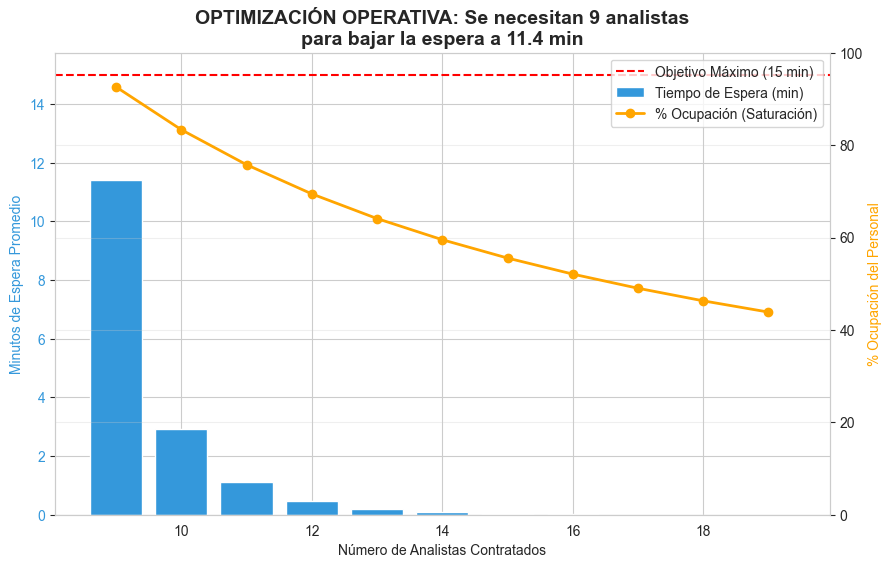

RECOMENDACIÓN DE GERENCIA (RRHH):
1. Escenario Crítico: Con 8 analistas, la espera se dispara exponencialmente.
2. Punto Óptimo: Contratar 9 personas.
   - Tiempo de Espera: 11.4 min (Cumple meta < 15).
   - Productividad: El equipo estará ocupado el 92.6% del tiempo.


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

print(">>> INICIANDO CÁLCULO DE INVESTIGACIÓN DE OPERACIONES...")

# ==========================================
# 1. PARÁMETROS DE ENTRADA (Datos del Problema)
# ==========================================
# Supongamos que tu modelo de XGBoost genera alertas que deben revisarse manualmente.
# Del análisis de Big Data (Poisson), sabemos cuántas alertas llegan por hora.

llegadas_por_hora = 50   # (Lambda): Llegan 50 alertas de fraude por hora promedio
tiempo_revision = 10     # Un humano tarda 10 minutos en revisar una alerta
nivel_servicio_objetivo = 15 # Queremos atender en máximo 15 minutos de espera

# Capacidad de un analista (Mu): ¿Cuántas revisa por hora?
# Si tarda 10 min, revisa 60/10 = 6 alertas por hora.
capacidad_analista = 60 / tiempo_revision 

print(f"DEMANDA: {llegadas_por_hora} alertas/hora")
print(f"CAPACIDAD INDIVIDUAL: {capacidad_analista} alertas/hora por persona")
print(f"MÍNIMO TEÓRICO DE PERSONAL: {llegadas_por_hora / capacidad_analista:.2f} personas (para que el sistema no colapse)")

# ==========================================
# 2. MODELO M/M/s (Teoría de Colas)
# ==========================================
def calcular_colas_mms(s, lam, mu):
    """
    Calcula métricas de espera dado un número de servidores (s).
    s: Número de analistas
    lam: Tasa de llegadas (Lambda)
    mu: Tasa de servicio (Mu)
    """
    rho = lam / (s * mu) # Factor de utilización
    if rho >= 1:
        return None # El sistema explota (colas infinitas)
    
    # Calcular Probabilidad de sistema vacío (P0) - Fórmula Erlang-C
    sumatoria = sum([(lam/mu)**n / math.factorial(n) for n in range(s)])
    term_s = ((lam/mu)**s / math.factorial(s)) * (1 / (1 - rho))
    p0 = 1 / (sumatoria + term_s)
    
    # Número promedio en cola (Lq)
    Lq = (p0 * (lam/mu)**s * rho) / (math.factorial(s) * (1 - rho)**2)
    
    # Tiempo promedio en cola (Wq) en minutos
    Wq = (Lq / lam) * 60 
    
    return Wq, rho

# ==========================================
# 3. SIMULACIÓN DE ESCENARIOS (¿Cuántos contrato?)
# ==========================================
escenarios = []
rango_personal = range(int(llegadas_por_hora/capacidad_analista) + 1, 20) # Probamos de 9 a 20 personas

for s in rango_personal:
    resultado = calcular_colas_mms(s, llegadas_por_hora, capacidad_analista)
    if resultado:
        tiempo_espera, ocupacion = resultado
        escenarios.append({
            'Analistas': s,
            'Tiempo_Espera_Min': tiempo_espera,
            'Ocupacion_Personal': ocupacion * 100
        })

df_optimizacion = pd.DataFrame(escenarios)

# ==========================================
# 4. VISUALIZACIÓN DE LA DECISIÓN
# ==========================================
fig, ax1 = plt.subplots(figsize=(10, 6))

# Eje Y1: Tiempo de Espera (Barras)
bars = ax1.bar(df_optimizacion['Analistas'], df_optimizacion['Tiempo_Espera_Min'], color='#3498db', label='Tiempo de Espera (min)')
ax1.set_xlabel('Número de Analistas Contratados')
ax1.set_ylabel('Minutos de Espera Promedio', color='#3498db')
ax1.tick_params(axis='y', labelcolor='#3498db')
ax1.axhline(y=nivel_servicio_objetivo, color='r', linestyle='--', label=f'Objetivo Máximo ({nivel_servicio_objetivo} min)')

# Eje Y2: Ocupación (Línea)
ax2 = ax1.twinx()
ax2.plot(df_optimizacion['Analistas'], df_optimizacion['Ocupacion_Personal'], color='orange', marker='o', linewidth=2, label='% Ocupación (Saturación)')
ax2.set_ylabel('% Ocupación del Personal', color='orange')
ax2.set_ylim(0, 100)

# Encontrar el óptimo (El primero que cumple < 15 min)
optimo = df_optimizacion[df_optimizacion['Tiempo_Espera_Min'] < nivel_servicio_objetivo].iloc[0]
plt.title(f'OPTIMIZACIÓN OPERATIVA: Se necesitan {int(optimo["Analistas"])} analistas\npara bajar la espera a {optimo["Tiempo_Espera_Min"]:.1f} min', fontsize=14, fontweight='bold')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.grid(True, alpha=0.3)
plt.show()

print("="*60)
print("RECOMENDACIÓN DE GERENCIA (RRHH):")
print(f"1. Escenario Crítico: Con {int(optimo['Analistas'])-1} analistas, la espera se dispara exponencialmente.")
print(f"2. Punto Óptimo: Contratar {int(optimo['Analistas'])} personas.")
print(f"   - Tiempo de Espera: {optimo['Tiempo_Espera_Min']:.1f} min (Cumple meta < {nivel_servicio_objetivo}).")
print(f"   - Productividad: El equipo estará ocupado el {optimo['Ocupacion_Personal']:.1f}% del tiempo.")
print("="*60)

In [20]:
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Asegúrate de tener las probabilidades calculadas del paso anterior
# probs_test = modelo_final.predict_proba(X_test)[:, 1] 

print(">>> INICIANDO DEMO INTEGRAL (IA + FINANZAS + MARKETING)...")

def tablero_mando_total(umbral):
    # 1. CÁLCULOS TÉCNICOS (IA)
    preds_ajustadas = (probs_test >= umbral).astype(int)
    cm = confusion_matrix(y_test, preds_ajustadas)
    tn, fp, fn, tp = cm.ravel()
    
    # Métricas IA
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # 2. CÁLCULOS FINANCIEROS (Dinero)
    dinero_salvado = tp * 50000 # Evitamos robos de 50k
    
    # 3. CÁLCULOS DE MERCADOTECNIA (La parte nueva)
    # Escenario: Cada falso positivo es un cliente furioso.
    clientes_enojados = fp
    
    # Estrategia de Recuperación: Enviar un "Bono de Disculpa" de $200 MXN a cada error
    costo_retencion = clientes_enojados * 200 
    
    # Proyección de NPS (Net Promoter Score)
    # Si bloqueamos a mucha gente, el NPS cae. Base de 70 puntos - penalización.
    nps_estimado = 70 - (clientes_enojados * 0.05) 
    if nps_estimado < -100: nps_estimado = -100
    
    # Estado de la Crisis de Marca
    if clientes_enojados > 500:
        estado_crisis = "🔴 CRÍTICO (Ola de quejas en Twitter)"
        accion_mkt = "ACTIVAR PROTOCOLO DE CRISIS + BONO $500"
        costo_retencion = clientes_enojados * 500 # Sube el costo si es crisis
    elif clientes_enojados > 100:
        estado_crisis = "🟠 ALERTA (Descontento moderado)"
        accion_mkt = "Enviar Email de Disculpa + Bono $200"
    else:
        estado_crisis = "🟢 ESTABLE (Operación normal)"
        accion_mkt = "Monitoreo estándar"

    # --- VISUALIZACIÓN ---
    plt.figure(figsize=(14, 7))
    
    # PANEL A: Matriz de Confusión (Técnico)
    plt.subplot(1, 2, 1)
    grupos = ['Clientes Felices', 'Falsos Positivos\n(CRISIS MKT)', 
              'Fraudes Fugados', 'Fraudes Atrapados']
    conteo_etiquetas = [f"{v1}\n{v2}" for v1, v2 in zip(grupos, cm.flatten())]
    etiquetas = np.asarray(conteo_etiquetas).reshape(2,2)
    sns.heatmap(cm, annot=etiquetas, fmt='', cmap=['#D5F5E3', '#FADBD8'], cbar=False,
                xticklabels=['Pred: OK', 'Pred: FRAUDE'], yticklabels=['Real: OK', 'Real: FRAUDE'])
    plt.title(f'Motor de IA (Umbral: {umbral:.2f})')
    
    # PANEL B: Reporte Ejecutivo (Negocio + Marketing)
    plt.subplot(1, 2, 2)
    plt.axis('off')
    
    texto_reporte = f"""
    TABLERO DE CONTROL ESTRATÉGICO
    ==================================================
    
    1. RENDIMIENTO TÉCNICO (Data Science)
       - Precisión: {precision:.1%}
       - Recall:    {recall:.1%}
       - F1-Score:  {f1:.1%} (Calidad del Modelo)
    
    2. IMPACTO FINANCIERO (Negocio)
       💰 Dinero Salvado:      ${dinero_salvado:,.0f}
       💸 Costo de Campaña:   -${costo_retencion:,.0f} (Gasto en retención)
       ---------------------------------------
       NETO (Profit):          ${dinero_salvado - costo_retencion:,.0f}
    
    3. MERCADOTECNIA DIGITAL & REPUTACIÓN (Nuevo)
       😠 Clientes Afectados:  {clientes_enojados} usuarios
       📉 NPS Proyectado:      {nps_estimado:.1f} pts
       
       📢 ESTADO REPUTACIONAL: {estado_crisis}
       🛡️ ACCIÓN SUGERIDA:     {accion_mkt}
    """
    
    # Color de fondo según ganancia neta
    bg_color = "#EAFAF1" if (dinero_salvado - costo_retencion) > 0 else "#Fdedec"
    
    plt.text(0.02, 0.05, texto_reporte, fontsize=11, fontfamily='monospace', 
             bbox=dict(facecolor=bg_color, edgecolor='gray', boxstyle='round,pad=1'))
    
    plt.tight_layout()
    plt.show()

# WIDGET
interact(tablero_mando_total, 
         umbral=widgets.FloatSlider(value=0.5, min=0.05, max=0.95, step=0.05, 
                                    description='Nivel Agresividad:', continuous_update=False));

>>> INICIANDO DEMO INTEGRAL (IA + FINANZAS + MARKETING)...


interactive(children=(FloatSlider(value=0.5, continuous_update=False, description='Nivel Agresividad:', max=0.…